# Customer dataset (Unsupervised Learning)

__Background__

You are running a shopping mall, and you have some data about your customers like
Age, Gender, Income and Spending.

# Dataset Description

This dataset contains: 

CustomerID: unique customer identifier

Gender: gender of the customer

Age: age of the customer

Income (k$): monthly income of the customer

How Much They Spend: spending score range from 0 - 100, the higher the score, the more they spend

I am to build a model which can identify the clusters in the data so as to find the most valuable group of customers for the mall so that they can do something to retain them

In [1]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances

import warnings
warnings.filterwarnings('ignore')

# Data import + Processing

In [2]:
# Import data using pandas
data = pd.read_csv("Customer_dataset.csv")
#Drop duplicates (if any)
data = data.drop_duplicates()
#Checking the size of dataset
print('Data shape:',data.shape, '\nData size:',data.size)

Data shape: (200, 5) 
Data size: 1000


# Data visualzation

First I print out the data information

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.4+ KB
None


Then I check the data for null values, which in this dataset there is none.

In [4]:
#Checking for missing values
print(data.isna().sum().sort_values())

CustomerID             0
Gender                 0
Age                    0
Income (k$)            0
How Much They Spend    0
dtype: int64


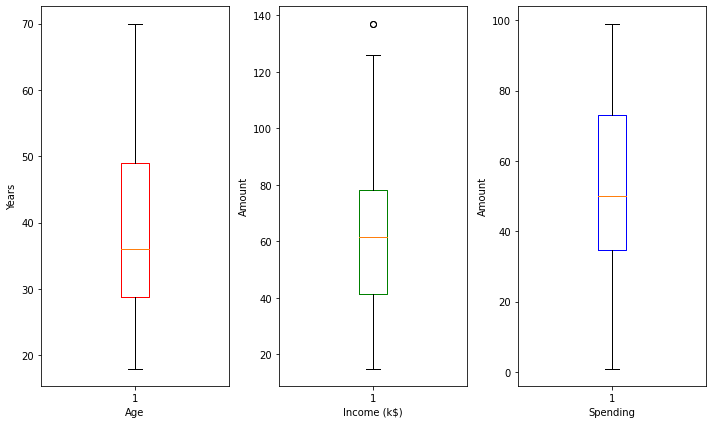

In [5]:
#Use boxplot to check for outliers

plt.figure(figsize=(10, 6))

plt.subplot(1,3, 1)
plt.boxplot(data['Age'], boxprops=dict(color='red'))
plt.xlabel('Age')
plt.ylabel('Years')

plt.subplot(1, 3, 2)
plt.boxplot(data['Income (k$)'], boxprops=dict(color='green'))
plt.xlabel('Income (k$)')
plt.ylabel('Amount')

plt.subplot(1, 3, 3)
plt.boxplot(data['How Much They Spend'], boxprops=dict(color='blue'))
plt.xlabel('Spending')
plt.ylabel('Amount')

plt.tight_layout()
plt.show()


In [6]:
#Removing outliers
IQR = data['Income (k$)'].quantile(0.75)-data['Income (k$)'].quantile(0.25)
Q3 = data['Income (k$)'].quantile(0.75)
data = data[data['Income (k$)'] < Q3+1.5*IQR]

I then plotted Histograms to find out more about the distribution of the features

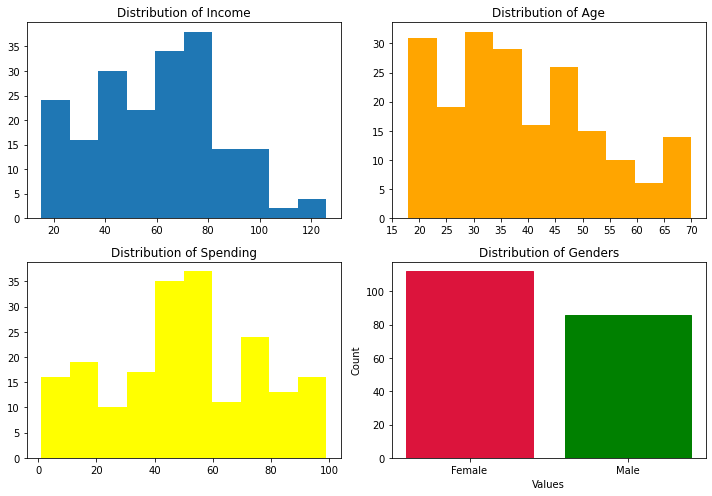

In [7]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
plt.hist(data['Income (k$)'],label='Income (k$)')
plt.title('Distribution of Income')

plt.subplot(2,2,2)
plt.hist(data['Age'],color='orange',label='Age')
plt.title('Distribution of Age')
plt.xticks(np.arange(15,75,5))

plt.subplot(2,2,3)
plt.hist(data['How Much They Spend'],color='yellow',label='Age')
plt.title('Distribution of Spending')

plt.subplot(2,2,4)
count = data['Gender'].value_counts()
barplot = plt.bar(count.index,count.values)
barplot[0].set_color('crimson')
barplot[1].set_color('green')
plt.title('Distribution of Genders')
plt.xticks([0,1])
plt.xlabel('Values')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

From the graphs, I can tell that Income is normally distributed with most people having an income of around 70k. From the Age distribution graph I can tell that Age is slightly skewed to the left, having peaks on Ages around 20, 30, 35, 47, and 67. 
I can also tell that Spending is normally distributed with most people having a spending score of around 50. The count plot tells me that there are more females than males in the data.

This is a heatmap which i plotted the correlation matrix of the features to see the correlation between each variables. By doing so, I can determine which features are greatly correlation to one another and remove that variable, removing noise and preventing multicollinearity.

Multicollinearity causes problems to the model as it becomes challenging to interpret the impact of the individual features and other huge problems

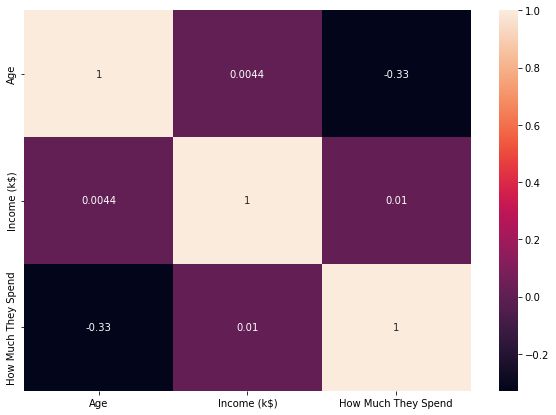

In [8]:
cor = data.drop(['CustomerID','Gender'], axis=1).corr()
plt.figure(figsize = (10,7))
sns.heatmap(cor,annot=True)
plt.show()

From the graph, I can tell that there are no features that are highly correlated with one another.

# Feature selection

__Gender__

Men outnumber women as a proportion of consumers who reported higher spending in these areas.(Online, Amazon, Waltmart.com, Walmart stores)

https://www.junglescout.com/blog/men-vs-women-shopping/

Most young men do not generally buy in sales and discounts whereas females prefer to. Most men spend more expenditure per trip as compared to women

https://www.irjet.net/archives/V9/i12/IRJET-V9I1217.pdf

From two different articles, I found the general trend is that men spend more expenditure per trip then woman do, and have vastly different shopping style. The type of product men tend to buy are also different which could have some effect on the higher expenditure. Thus I decided to keep Gender.

__Age__

In a survey on shopping behavior in Singapore conducted by Rakuten Insight, 40 percent of respondents aged 35 to 44 years stated that they spent between 50 to 100 Singapore dollars per shopping trip in a physical store. On the other hand, 50 percent of respondents aged 16 to 24 years stated that they spent on average less than 50 Singapore dollars each time they went offline shopping.
 
https://www.statista.com/statistics/1272349/singapore-average-spending-per-offline-shopping-trip-by-age-group/#statisticContainer

The frequent mall shopper has been identified as an individual between 40-60 years old. The only consumer groups shopping at malls in greater numbers today are teen and senior citizens. Both groups have more free time for recreational shooping than do baby boomers. In fact teens are definiety the most frequent visitors to shopping malls. Many malls have decided that the teenage market is clearly critical to the success while, people over aged 50 have also been targetted by retailers since they control more than three fourths of the nation's wealth.

https://jrdelisle.com/JSCR/IndArticles/Kang_N196.pdf 
 
From two different articles, although the context of the research are not exactly the same since they are conducted in different countries, the general trend of age have different expenditure , partly due to maturity and disposable income, which is enough to show that Age will have an impact in sorting out clusters. Thus I decided to keep the Age column.

__Income__

Variety and income levels are positively  correlated, showing that with an increase in income levels consumers have access to an increased variety of products. Prices and income levels are  moderately  positively  correlated  which  indicates  that consumers with a  higher  income level purchase  brands  with higher  prices. The  study  further  reveals that  there  is  a  moderate  positive correlation between price and quality of the product, which is obviously true. As the income increases, the consumer wants to try better quality products even at slightly higher prices. 

https://www.researchgate.net/publication/323771786_Influence_of_income_on_the_shopping_habits_of_consumers_with_respect_to_shopping_malls_in_Kolkata_city

Furthermore, I found something called the income effect. 

"The income effect, in microeconomics, is the resultant change in demand for a good or service caused by an increase or decrease in a consumer's purchasing power or real income. As one's income grows, the income effect predicts that people will begin to demand more"

This is an effect that affects businesses since the increase or decrease of consumer's income will affect the purchasing power of the customers which in turn will affect businesses. Thus I decided to keep the Income column since the income of individuals will affect the expenditure which in turn can decide which cluster is good for the mall.

https://www.investopedia.com/terms/i/incomeeffect.asp

__How much they spend__

Shows a score range from 0 - 100, the higher the score, the more the customers spend which is a very good gauge for finding out which clusters is valuable to the mall.

# Using PCA for dimensional reduction

Firstly, I used StandardScaler to standardize the data

In [9]:
X_gender = data.drop(['CustomerID'], axis=1)
X_gender['Gender'] = X_gender['Gender'].replace({'Male': 0, 'Female': 1})
X = data.drop(['CustomerID','Gender'], axis=1)
X_standard = StandardScaler().fit_transform(X)
X_standard = pd.DataFrame(X_standard, columns= X.columns)
X_standard.head()

,Age,Income (k$),How Much They Spend
0,-1.425414,-1.779171,-0.435989
1,-1.282367,-1.779171,1.199413
2,-1.353890,-1.739447,-1.720949
3,-1.139319,-1.739447,1.043661
4,-0.567131,-1.699723,-0.397051


In [10]:
# implementing PCA
pca = PCA(n_components=3).fit(X_standard)
pca_samples = pca.transform(X_standard)

In [11]:
# Computes the PCs and percentage variance explained
# Pass original data and returns of PCA to this function.
# This function returns a table summarising the eigenvalues, % variance explained, cumulative % variance explained and PCs

def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions
    
    #PCA cumulative explained variance
    cum_var_ratio = variance_ratios.cumsum()
    cum_var_ratio.columns = ['Cumulative Explained variance']
    

    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios, cum_var_ratio, components], axis = 1)

In [12]:
pca_results = pca_results(X_standard, pca)
pca_results

,Eigenvalue,Explained Variance,Cumulative Explained variance,Age,Income (k$),How Much They Spend
PC 1,1.3362,0.4432,0.4432,0.7069,-0.0122,-0.7072
PC 2,1.0053,0.3334,0.7766,0.0306,0.9994,0.0133
PC 3,0.6737,0.2234,1.0000,-0.7066,0.0311,-0.7069


<Figure size 432x288 with 0 Axes>

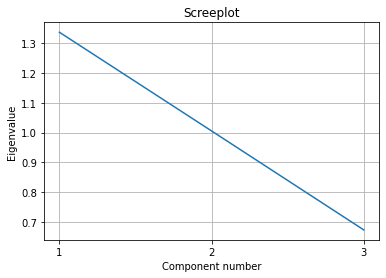

In [13]:
#Scree plot

plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
plt.grid(True)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set(xlabel = 'Component number', ylabel = 'Eigenvalue', title = 'Screeplot')
plt.show()

Determining which PC to keep:

From the Screeplot, there is no elbow thus it could suggest that I should keep all 3 PCs

By Kaiser’s Rule, the first 2 PCs have eigenvalues that are > 1 suggesting that I should keep 2 PCs.

By  looking at the percentage of total variance, it suggests that I should keep 3 PCs since the total cumulative variance at 3 PCs is about 100% while 2 PCs will have a total cumulative variance of about 77.66 which is insufficient.


Thus I decided to keep all 3 PCs

In [14]:
#Extract three PCs
pca3 = PCA(n_components=3).fit(X_standard)
scores = pca3.transform(X_standard)

# Plotting Loading Plots

I plot loadings plots to get a better understanding on what the PCs captured.

In [15]:
def loadingplot(data, pca, width=12, height=5, margin=0.5):

    fig, axs = plt.subplots(1, 3, figsize=(width, height))

    for i, ax in enumerate(axs):
        pc1 = i
        pc2 = (i + 1) % pca.components_.shape[0]  # Wrap around to the first PC for the third plot

        # Set limits for the figure
        x_min = min(pca.components_[pc1, :].min(), 0) - margin
        x_max = max(pca.components_[pc1, :].max(), 0) + margin
        y_min = min(pca.components_[pc2, :].min(), 0) - margin
        y_max = max(pca.components_[pc2, :].max(), 0) + margin

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Scaling factor for text position
        text_pos = 0.1

        for j, v in enumerate(pca.components_.T):
            ax.arrow(0, 0, v[pc1], v[pc2], head_width=0.1, head_length=0.1, linewidth=2, color='red')
            ax.text(v[pc1], v[pc2] + text_pos, data.columns[j], color='black', ha='center', va='center', fontsize=10)

        ax.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
        ax.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
        ax.set_xlabel(f"PC{pc1+1}", fontsize=14)
        ax.set_ylabel(f"PC{pc2+1}", fontsize=14)
        ax.set_title(f"Loading plot (PC{pc1+1} vs PC{pc2+1})", fontsize=14)

    plt.tight_layout()

    return axs


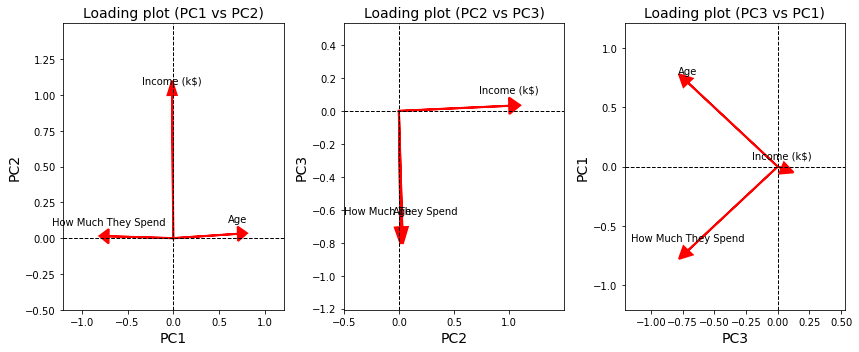

In [16]:
plt.clf
ax2 = loadingplot(X_standard, pca3)  # Students to fill in
plt.show()

# The interpretation of the loading plots

The loading plots shows that Income have little to none effect on PC1. The spenditure of the customers and Age affects PC1 alot. Age is going the opposite direction from How Much They Spend.

The loading plots shows that Age and Spenditure has little effect on PC2. Income affects PC2 alot. 

The loadings plots shows that Income has little effect on PC3. Gender and Income affects PC2 alot. Age and How Much They Spend are going in the same direction.

In [17]:
pca_results

,Eigenvalue,Explained Variance,Cumulative Explained variance,Age,Income (k$),How Much They Spend
PC 1,1.3362,0.4432,0.4432,0.7069,-0.0122,-0.7072
PC 2,1.0053,0.3334,0.7766,0.0306,0.9994,0.0133
PC 3,0.6737,0.2234,1.0000,-0.7066,0.0311,-0.7069


PC1 = 0.7069x1 - 0.0122x2 - 0.7072x3

PC2 = 0.0306x1 - 0.9994x2 - 0.0133x3

PC3 = -0.7066x1 + 0.0311x2 - 0.7069x3

__PC1__

From these loadings, I can tell that from PC1, the loading on Income seem smaller than the other loadings

The loading on Age are opposite in sign to the loading on How Much They Spend.

This PC seems to measure the contrast between the Age of the customer and the expenditure of the customer with little to no emphasis on Income.

__PC2__

From these loadings, I can tell that from PC2, the loading on Age and How Much They  Spend seem smaller than the other loadings

This PC seems to measure the general income of the customers.

__PC3__

From these loadings, I can tell that from PC3, the loading on Income seem smaller than the other loadings

The loading on Age and How Much They Spend have the same sign

This PC seems to measure the general age to expenditure relation


# Choosing Clustering Model

__KMeans__

I used KMeans since it is made for general purpose and it is well-suited for evenly sized, well-separated clusters, thus if there are distinct groups of customers based on age, gender, income, and spending score, K-means can effectively identify them.

__Ward hierarchical clustering__

I used Ward hierarchical clustering instead of Agglomerative Clustering as the data does not does not involve non-Euclidean distance measures.It is suitable for datasets where the focus is on understanding the hierarchical organization of customer segments.

__Gaussian Mixture__

I used Gaussian Mixture as if there are overlapping patterns in customer attributes, GMM can provide more accurate clustering results than K-means. It is particularly suitable for datasets with non-linearly separable data and when there are complex relationships between customer attributes. 

By using KMeans, Ward hierarchical clustering, and Gaussian Mixture, I can explore different clustering perspectives and gain insights into the data from multiple angles. Each algorithm's strengths and capabilities complement one another, enhancing the overall understanding of customer segments and revealing unique patterns in the data.

# Finding Optimal Number of Clusters for KMeans

For n_clusters=2, The Silhouette Coefficient is 0.334
For n_clusters=3, The Silhouette Coefficient is 0.356
For n_clusters=4, The Silhouette Coefficient is 0.406
For n_clusters=5, The Silhouette Coefficient is 0.421
For n_clusters=6, The Silhouette Coefficient is 0.433
For n_clusters=7, The Silhouette Coefficient is 0.423
For n_clusters=8, The Silhouette Coefficient is 0.412
For n_clusters=9, The Silhouette Coefficient is 0.419
For n_clusters=10, The Silhouette Coefficient is 0.400


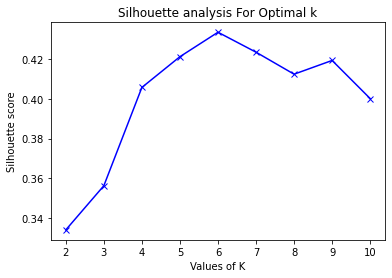

In [18]:
# Clustering silhouette_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil_scores = []
# trying different number of clusters
for k in range(2, 11):
    model = KMeans(n_clusters=k,random_state=20).fit(scores)
    label = model.labels_
    sil_coeff = silhouette_score(scores, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {:.3f}".format(k,sil_coeff))
    sil_scores.append(sil_coeff)
    
plt.plot(range(2,11),sil_scores,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

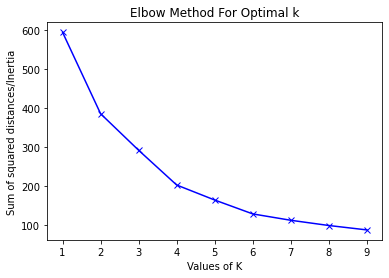

In [19]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters,random_state=20)
    kmeans.fit(scores)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

# Optimizing KMeans Hyperparameters

In [20]:
kmeans = KMeans(n_clusters=6,random_state=20)

# Define a custom scoring function using silhouette_score
def custom_silhouette_score(estimator, scores):
    labels = estimator.fit_predict(scores)
    return silhouette_score(scores, labels)

param_grid = {
    'init': ['k-means++', 'random'],         # Initialization method
    'max_iter': [100, 300, 500],             # Maximum number of iterations
    'tol': [1e-4, 1e-3, 1e-2],               # Convergence tolerance
}

kmeans_grid = GridSearchCV(estimator=kmeans, param_grid=param_grid, scoring=custom_silhouette_score, cv=5)

# Perform the grid search
kmeans_grid.fit(scores)

# Print the best parameters and corresponding silhouette score
print("Best Parameters:", kmeans_grid.best_params_)
print("Best Silhouette Score:", kmeans_grid.best_score_)

Best Parameters: {'init': 'k-means++', 'max_iter': 100, 'tol': 0.0001}
Best Silhouette Score: 0.3791166698233903


# Final KMeans Model

In [21]:
kmeans = KMeans(n_clusters=6,random_state=20, init='k-means++', max_iter=100,tol=0.0001)
kmeans.fit(scores)
km_pred = kmeans.predict(scores)

<IPython.core.display.Javascript object>


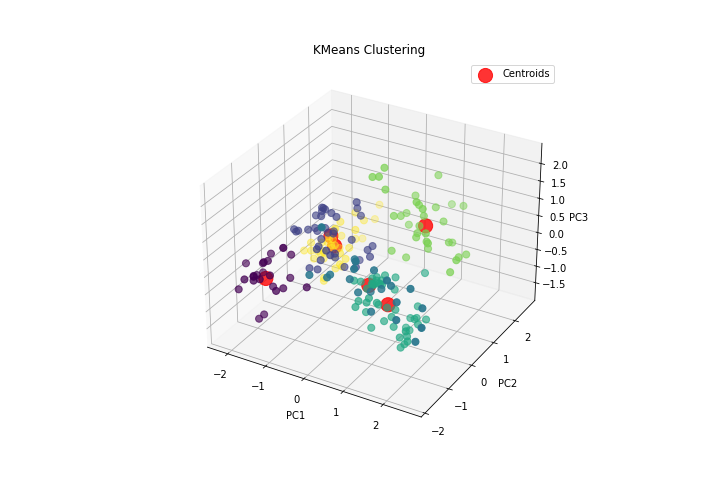

<IPython.core.display.Javascript object>


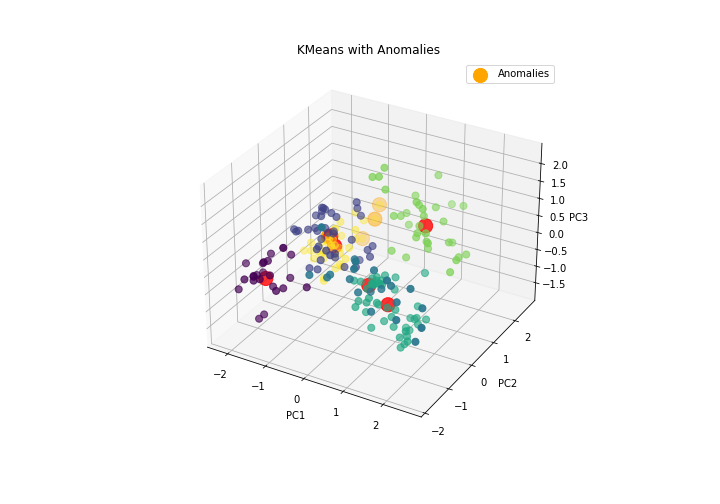

<IPython.core.display.Javascript object>


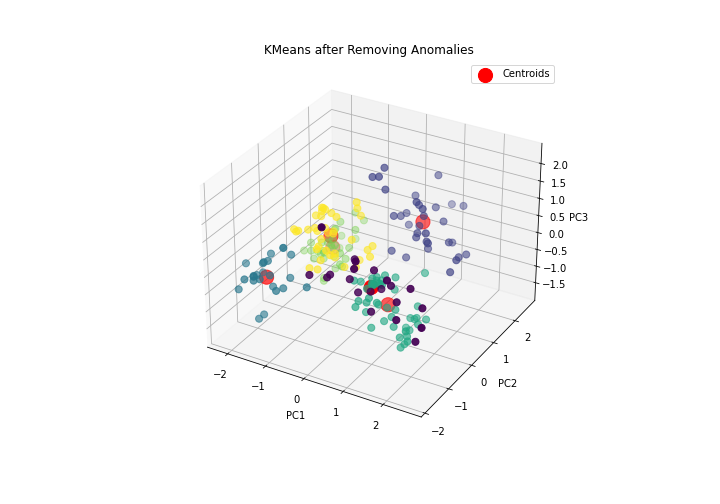

In [44]:
#KMeans Clustering
%matplotlib notebook

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scores[:,0], scores[:,1],scores[:,2], c=km_pred, s=50, cmap='viridis')
plt.title("KMeans Clustering")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
km_centers = kmeans.cluster_centers_
ax.scatter(km_centers[:, 0],km_centers[:,1], km_centers[:, 2], c='red', s=200, alpha=0.8, label='Centroids')
plt.legend()
plt.show()

# Calculate cluster centers (means) in the reduced PCA space
km_cluster_centers = kmeans.cluster_centers_
# Calculate the distance between data points and their cluster centers
km_distances_to_centers = np.linalg.norm(scores - km_cluster_centers[km_pred], axis=1)

# Set an anomaly threshold (2 standard deviations from the mean)
km_anomaly_threshold = np.mean(km_distances_to_centers) + 2 * np.std(km_distances_to_centers)

# Identify anomalies
km_anomalies_indices = np.where(km_distances_to_centers > km_anomaly_threshold)[0]
km_anomalies = scores[km_anomalies_indices]

#Plot Anomalies
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scores[:,0], scores[:,1] ,scores[:,2], c=km_pred, s=50, cmap='viridis')
plt.title("KMeans with Anomalies")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.scatter(km_centers[:, 0], km_centers[:,1],km_centers[:, 2], c='red', s=200, alpha=0.8)
ax.scatter(km_anomalies[:, 0],km_anomalies[:,1], km_anomalies[:, 2], c='orange', marker='o', s=200, label='Anomalies')
plt.legend()
plt.show()

#Removing Anomalies
km_new_data = np.delete(scores, km_anomalies_indices, axis=0)
kmeans.fit(km_new_data)
km_updated_cluster_centers = kmeans.cluster_centers_
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(km_new_data[:, 0], km_new_data[:,1],km_new_data[:, 2], c=kmeans.labels_, cmap='viridis',s=50)
ax.scatter(km_updated_cluster_centers[:, 0],km_updated_cluster_centers[:,1], km_updated_cluster_centers[:, 2], c='red',s=200, label='Centroids')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title('KMeans after Removing Anomalies')
plt.legend()

plt.show()

# KMeans Evaluation

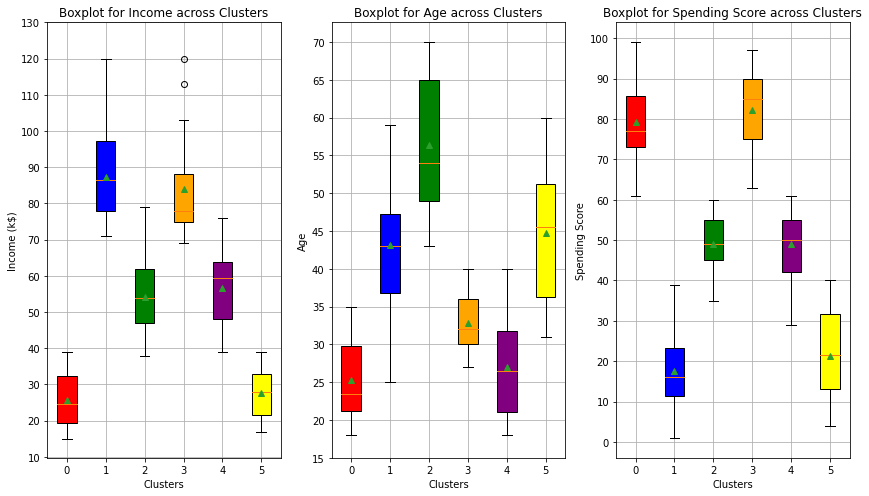

In [23]:
%matplotlib inline
km_data = pd.DataFrame(X_gender)
km_data = km_data.drop(km_anomalies_indices)
km_data['cluster'] = kmeans.labels_
grouped_data =km_data.groupby('cluster')
cluster_labels = list(grouped_data.groups.keys())
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan']
rgba_colors = [mcolors.to_rgba(color) for color in colors]

# Extract the data for the specified feature column for each cluster
gendercluster = [grouped_data.get_group(cluster_label)['Gender'] for cluster_label in grouped_data.groups]
agecluster = [grouped_data.get_group(cluster_label)['Age'] for cluster_label in grouped_data.groups]
incomecluster = [grouped_data.get_group(cluster_label)['Income (k$)'] for cluster_label in grouped_data.groups]
spendingcluster = [grouped_data.get_group(cluster_label)['How Much They Spend'] for cluster_label in grouped_data.groups]


plt.figure(figsize=(12, 7))
# Plot for 'Income'
plt.subplot(1, 3, 1)
income_boxplot = plt.boxplot(incomecluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(income_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Income across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Income (k$)')
plt.yticks(np.arange(10, 140, 10))
plt.grid(True)

# Plot for 'Age'
plt.subplot(1, 3, 2)
age_boxplot = plt.boxplot(agecluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(age_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Age across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Age')
plt.yticks(np.arange(15, 75, 5))
plt.grid(True)

# Plot for 'Spending Score'
plt.subplot(1, 3, 3)
spending_boxplot = plt.boxplot(spendingcluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(spending_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Spending Score across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Spending Score')
plt.yticks(np.arange(0, 110, 10))
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
km_data_mean = km_data.groupby('cluster').mean()

print("Mean of each cluster in the original feature space after removing anomalies:")
km_data_mean

Mean of each cluster in the original feature space after removing anomalies:


,Gender,Age,Income (k$),How Much They Spend
cluster,,,,
0,0.590909,25.272727,25.727273,79.363636
1,0.464286,43.178571,87.392857,17.607143
2,0.577778,56.333333,54.266667,49.066667
3,0.567568,32.783784,84.108108,82.324324
4,0.657895,27.000000,56.657895,49.131579
5,0.666667,44.722222,27.666667,21.333333


# KMeans Characteristics of Each Customer Clusters

__Cluster 0__

The customers in this cluster have a fairly narrow age range of about 18 to 35. The mean age of this cluster is around 25, which falls within the range of young adults. The customers in this cluster have the lowest income compared to the rest of the clusters with an income range of about 15k to 39k. The mean income of this cluster is 25.7k .These customers have a spending score range of about 61 to 99 and a mean spending score of about 79.4/100 which really surprising since their income is the lowest yet these customers are spending almost as much as customer who double their income. Based on their spending behavior, it appears that these customers may be spendthrifts, meaning they tend to spend money freely and often exceed their income levels. They may have specific spending habits or preferences that contribute to their higher spending scores despite their lower income and is certainly a contender for being the most valuable cluster for the mall.

__Cluster 1__

The customers in this cluster have a really wide age range of about 25 to 58. The mean age of this cluster is around 43, which falls within the range of middle aged adults. The customers in this cluster have the highest income among the clusters with an income range of about 71k to 120k. The mean income of this cluster is 87.4k. These customers have a spending score range of about 1 to 39 and a mean spending score of about 17.6/100 which is surprising due to their high income but is not really significant to the mall.

__Cluster 2__

The customers in this cluster have a fairly wide age range of about 43 to 70. The mean age of this cluster is around 56, which falls within the range of seniors. The customers in this cluster have an average income compared to the rest of the clusters with an income range of about 38k to 79k. The mean income of this cluster is 54.3k. These customers have a spending score range of about 35 to 60 and a mean spending score of about 49.0/100 which is not really significant to the mall.

__Cluster 3__

The customers in this cluster have a narrow age range of about 34 to 40. The mean age of this cluster is around 33, which falls within the range of early middle aged adults. The customers in this cluster have an income on the higher side as compared to the some of the clusters with an income range of about 69k to 103k, without counting the outliers. The mean income of this cluster is 84.1k. These customers have a spending score range of about 63 to 97 and a mean spending score of about 82.3/100 which is noteworthy and certainly a contender for being the most valuable cluster for the mall.

__Cluster 4__

The customers in this cluster have an age range of about 18 to 40. The mean age of this cluster is 27, which falls within the range of young adults. The customers in this cluster have an average income with an income range of about 39k to 76k. The mean income of this cluster is 56.7k. These customers have a spending score range of about 29 to 61 and a mean spending score of about 49.1/100  which is not really significant to the mall.

__Cluster 5__

The customers in this cluster have an age range of about 31 to 60. The mean age of this cluster is around 48, which falls within the range of middle aged adults. The customers in this cluster have an income on the lower side as compared to the rest of the clusters with an income range of about 18k to 39k. The mean income of this cluster is 27.7k. These customers have a spending score range of about 4 to 40 and a mean spending score of about 21.3/100 which is not really significant to the mall.

# KMeans Conclusion

Overall, Cluster 0, young adults with a spendthrift nature and an average income of 25.7k, Cluster 3, early middle aged adults with an average income of 75k are very valuble clusters to the mall. ( I used the term early middle aged adults since i want to distinguish the group with a mean age of 25 comapared to the mean of 33 which technically both falling under young adults) 

However __Cluster 3 is the most valuable cluster__ due to its relatively small interquartile range of spending scores, coupled with the highest mean spending scores among all clusters.

# Finding Optimal Number of Clusters for Ward Hierarchical Clustering

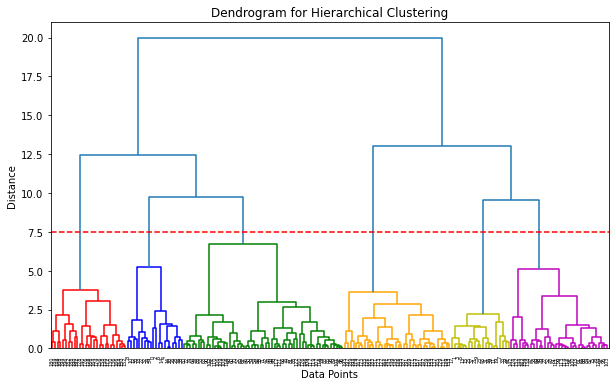

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

# Create the linkage matrix
linkage_matrix = linkage(scores, method='ward')


threshold_distance = 7.5

# Create and plot the dendrogram with customized colors
plt.figure(figsize=(10, 6))

# Customize link colors
hierarchy.set_link_color_palette(['r', 'b', 'g', 'orange', 'y', 'm'])

# Create the dendrogram
dendrogram(linkage_matrix, color_threshold=threshold_distance)

# Reset link color palette after use
hierarchy.set_link_color_palette(None)
plt.axhline(y=7.5, color='r', linestyle='--', label='Distance Threshold')
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.title("Dendrogram for Hierarchical Clustering")
plt.show()

I used a dendrogram to visualize the clusters that the data could be split into.
I have decided to set the distance threshold to around 7.5 because it results in more evenly sized clusters compared to using a threshold of 10. Additionally, a threshold above 12 seems to provide clusters that lacks detail for my analysis.

# Comaparing Dendrogram with Silhouette Score Method

For n_clusters=2, The Silhouette Coefficient is 0.320
For n_clusters=3, The Silhouette Coefficient is 0.339
For n_clusters=4, The Silhouette Coefficient is 0.369
For n_clusters=5, The Silhouette Coefficient is 0.401
For n_clusters=6, The Silhouette Coefficient is 0.426
For n_clusters=7, The Silhouette Coefficient is 0.416
For n_clusters=8, The Silhouette Coefficient is 0.428
For n_clusters=9, The Silhouette Coefficient is 0.415
For n_clusters=10, The Silhouette Coefficient is 0.408


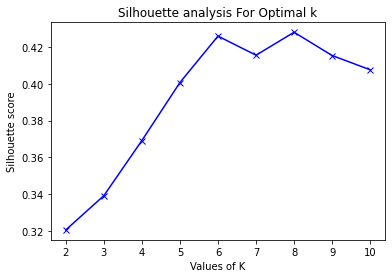

In [27]:
%matplotlib inline
# Clustering silhouette_score
sil_scores = []
# trying different number of clusters
for k in range(2, 11):
    model = AgglomerativeClustering(n_clusters=k,linkage='ward')
    label = model.fit_predict(scores)
    sil_coeff = silhouette_score(scores, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {:.3f}".format(k,sil_coeff))
    sil_scores.append(sil_coeff)
    
plt.plot(range(2,11),sil_scores,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

# Optimizing Ward Hierarchical Clustering Hyperparameters

In [28]:
# Hierarchical Clustering

agglomerative_clustering = AgglomerativeClustering(n_clusters = 6, linkage='ward')

# Define a custom scoring function using silhouette_score
def custom_silhouette_score(estimator, scores):
    labels = estimator.fit_predict(scores)
    return silhouette_score(scores, labels)

param_grid = {
    'connectivity': [None, [[1, 1], [1, 1]]],
    'distance_threshold': [None, 2.0, 5.0, 10.0]
}

ac_grid = GridSearchCV(estimator=agglomerative_clustering, param_grid=param_grid, scoring=custom_silhouette_score, cv=5)

# Perform the grid search
ac_grid.fit(scores)

# Print the best parameters and corresponding silhouette score
print("Best Parameters:", ac_grid.best_params_)
print("Best Silhouette Score:", ac_grid.best_score_)

Best Parameters: {'connectivity': None, 'distance_threshold': None}
Best Silhouette Score: 0.37363045474759954


In [29]:
agglomerative_clustering = AgglomerativeClustering(n_clusters = 6,connectivity=None, distance_threshold= None, linkage='ward')
ac_pred = agglomerative_clustering.fit_predict(scores)

<IPython.core.display.Javascript object>


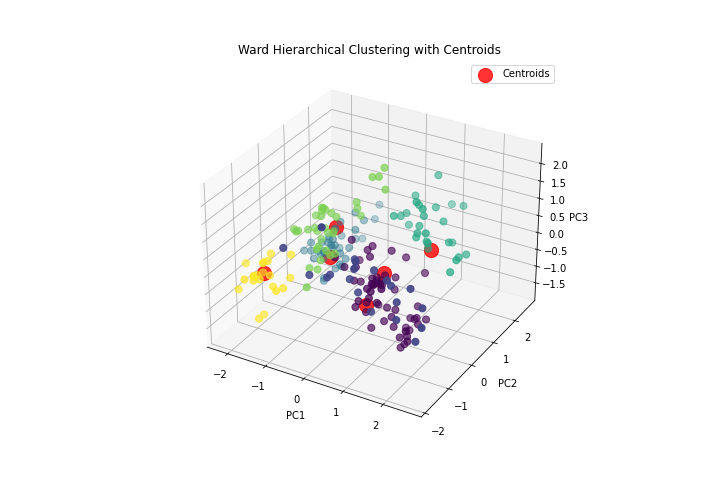

<IPython.core.display.Javascript object>


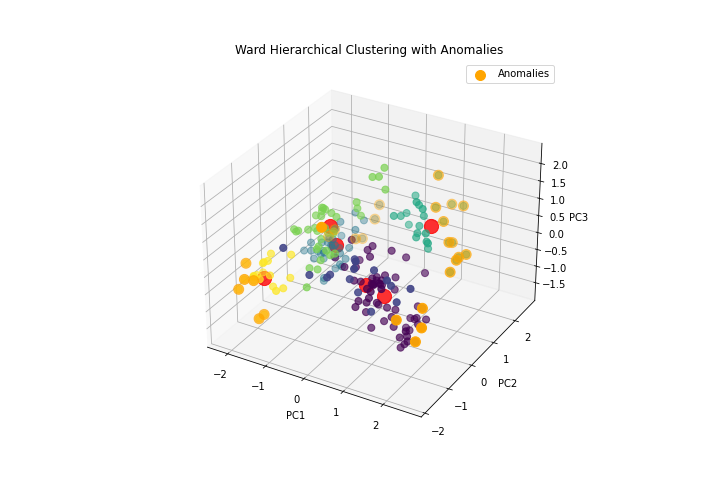

<IPython.core.display.Javascript object>


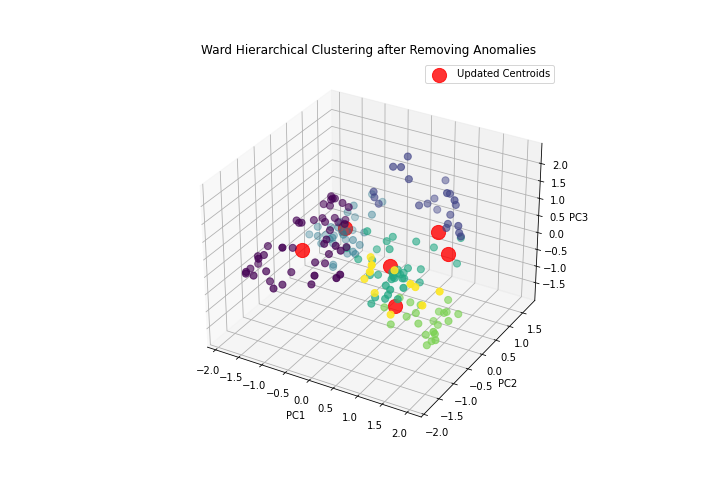

In [43]:
# Calculate centroids for each cluster
%matplotlib notebook
ac_centroids = []
for cluster_id in range(6):
    cluster_points = scores[ac_pred == cluster_id]
    centroid = np.mean(cluster_points, axis=0)
    ac_centroids.append(centroid)
    
# Scatter plot of data points and centroids
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scores[:, 0],scores[:, 1], scores[:, 2], c=ac_pred, cmap='viridis', s=50)
for i, centroid in enumerate(ac_centroids):
    plt.scatter(centroid[0], centroid[1], c='red', s=200, alpha=0.8, label='Centroids' if i == 0 else '')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("Ward Hierarchical Clustering with Centroids")
plt.legend()
plt.show()

# Calculate distances between data points and cluster representatives
ac_distances = euclidean_distances(scores, ac_centroids)

# Set anomaly threshold (mean + 2 * std)
ac_anomaly_threshold = np.mean(ac_distances) + 2 * np.std(ac_distances)

# Identify anomalies
ac_anomalies_indices = np.where(np.max(ac_distances, axis=1) > ac_anomaly_threshold)[0]
ac_anomalies = scores[ac_anomalies_indices]

# Visualize data and anomalies
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2], c=ac_pred, cmap='viridis', s=50)
for i, centroid in enumerate(ac_centroids):
    ax.scatter(centroid[0], centroid[1], centroid[2], c='red', s=200, alpha=0.8)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("Ward Hierarchical Clustering with Anomalies")
ax.scatter(ac_anomalies[:, 0], ac_anomalies[:, 1], ac_anomalies[:, 2], c='orange', marker='o', s=100, label='Anomalies')
plt.legend()
plt.show()

#Removing Anomalies
ac_new_data = np.delete(scores, ac_anomalies_indices, axis=0)
ac_new_pred = agglomerative_clustering.fit_predict(ac_new_data)

#Updated Clustering
ac_updated_centroids = []
for cluster_id in range(7):
    cluster_points = ac_new_data[ac_new_pred == cluster_id]
    centroid = np.mean(cluster_points, axis=0)
    ac_updated_centroids.append(centroid)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ac_new_data[:, 0], ac_new_data[:, 1], ac_new_data[:, 2], c=ac_new_pred, cmap='viridis',s=50)
for i, updated_centroid in enumerate(ac_updated_centroids):
    ax.scatter(updated_centroid[0], updated_centroid[2], c='red', s=200, alpha=0.8, label='Updated Centroids' if i == 0 else '')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title('Ward Hierarchical Clustering after Removing Anomalies')
plt.legend()

plt.show()

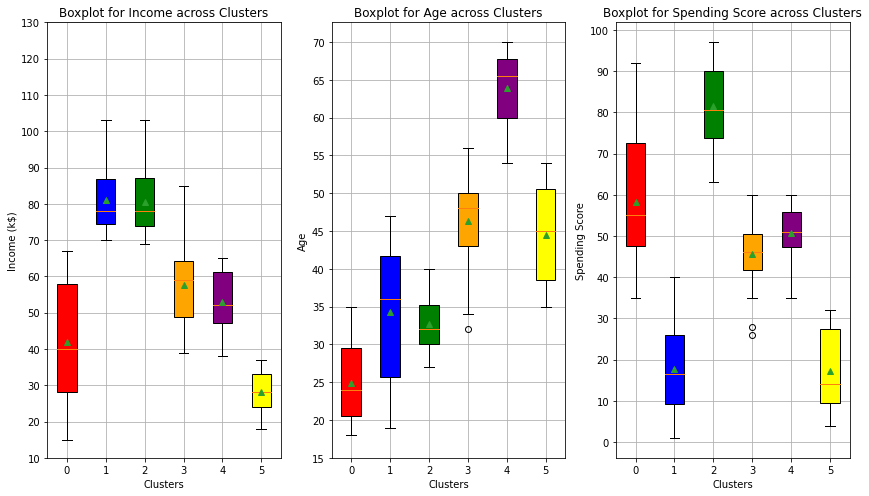

In [33]:
%matplotlib inline
WardHierarchical = pd.DataFrame(X_gender)
WardHierarchical = WardHierarchical.drop(ac_anomalies_indices)
WardHierarchical['cluster'] = ac_new_pred
grouped_data =WardHierarchical.groupby('cluster')
cluster_labels = list(grouped_data.groups.keys())
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan']
rgba_colors = [mcolors.to_rgba(color) for color in colors]

# Extract the data for the specified feature column for each cluster
agecluster = [grouped_data.get_group(cluster_label)['Age'] for cluster_label in grouped_data.groups]
incomecluster = [grouped_data.get_group(cluster_label)['Income (k$)'] for cluster_label in grouped_data.groups]
spendingcluster = [grouped_data.get_group(cluster_label)['How Much They Spend'] for cluster_label in grouped_data.groups]


plt.figure(figsize=(12, 7))
# Plot for 'Income'
plt.subplot(1, 3, 1)
income_boxplot = plt.boxplot(incomecluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(income_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Income across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Income (k$)')
plt.yticks(np.arange(10, 140, 10))
plt.grid(True)

# Plot for 'Age'
plt.subplot(1, 3, 2)
age_boxplot = plt.boxplot(agecluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(age_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Age across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Age')
plt.yticks(np.arange(15, 75, 5))
plt.grid(True)

# Plot for 'Spending Score'
plt.subplot(1, 3, 3)
spending_boxplot = plt.boxplot(spendingcluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(spending_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Spending Score across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Spending Score')
plt.yticks(np.arange(0, 110, 10))
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
#Calculate mean of each cluster in the original feature space
ac_data_mean = WardHierarchical.groupby('cluster').mean()

print("Mean of each cluster in the original feature space:")
ac_data_mean

Mean of each cluster in the original feature space:


,Gender,Age,Income (k$),How Much They Spend
cluster,,,,
0,0.574468,24.914894,41.872340,58.148936
1,0.500000,34.318182,80.954545,17.818182
2,0.531250,32.656250,80.593750,81.437500
3,0.638889,46.305556,57.555556,45.555556
4,0.454545,63.909091,53.045455,50.636364
5,0.727273,44.454545,28.000000,17.363636


# Ward Hierarchical Clustering Characteristics of Each Customer Clusters

__Cluster 1__

The customers in this cluster have a really wide age range of about 18 to 35. The mean age of this cluster is around 25, which falls within the range of young adults. The customers in this cluster have a low income compared to the rest of the clusters with an income range of about 15k to 68k. The mean income of this cluster is 41.9k. These customers have a wide spending score range of about 35 to 92 and a mean spending score of about 58.1/100 which is not really significant to the mall.

__Cluster 1__

The customers in this cluster have surprisingly an even spread of gender. They have a fairly wide age range of about 43 to 70. The mean age of this cluster is around 34, which falls within the range of middle aged adults. The customers in this cluster have the highest income with an income range of about 70k to 103k. The mean income of this cluster is about 81.0k. These customers have a spending score range of about 1 to 40 and a mean spending score of about 17.8/100 which is surprising due to their high income but is not really significant to the mall.

__Cluster 2__

The customers in this cluster a have a fairly narrow age range 27 to 40. The mean age of this cluster is around 33, which falls within the range of early middle aged adults. The customers in this cluster have a fairly high income compared to the rest of the clusters with an income range of about 69k to 103k. The mean income of this cluster is 80.6k . These customers have a spending score range of about 63 to 97 and a mean spending score of about 81.4/100 which is noteworthy and certainly a contender for being the most valuable cluster for the mall.

__Cluster 3__

The customers in this cluster have an age range of about 34 to 56. The mean age of this cluster is around 46, which falls within the range of middle aged adults. The customers in this cluster have an average income with an income range of about 39k to 85k. The mean income of this cluster is 57.6k. These customers have a spending score range of about 35 to 60 and a mean spending score of about 45.6/100 which is not really significant to the mall.

__Cluster 4__

The customers in this cluster have an age range of about 54 to 70. The mean age of this cluster is around 64, which falls within the range of seniors. The customers in this cluster have an average income with an income range of about 38k to 65k. The mean income of this cluster is 53.0k. These customers have a spending score range of about 35 to 60 and a mean spending score of about 50.6/100 which is not really significant to the mall.

__Cluster 5__

The customers in this cluster have a fairly wide age range of about 35 to 54. The mean age of this cluster is around 44, which falls within the range of middle aged adults. The customers in this cluster have the lowest income with an income range of about 18k to 37k. The mean income of this cluster is 28.0k. These customers have a spending score range of about 4 to 32 and a mean spending score of about 17.4/100 which is not really significant to the mall.

# Ward Hierarchical Clustering Conclusion

Overall, only one cluster is a contender for the most valuable cluster, Cluster 2, early middle aged adults with an average income of about 80.6k

__Cluster 2 is the most valuable cluster__ for the mall as they have a spending score range with a small interquartile range and also have the highest spending score mean. I assume these customers are affluent and have a tendency to prefer luxury or upscale shopping, making them a highly important target group for the mall's premium products and services. Their considerable income of 80.6k suggests strong purchasing power, and their spending behavior within a narrow range signifies consistent and substantial spending habit.

# Finding Optimal Number of Clusters for Gaussian Mixture

For n_clusters=2, The Silhouette Coefficient is 0.326
For n_clusters=3, The Silhouette Coefficient is 0.341
For n_clusters=4, The Silhouette Coefficient is 0.378
For n_clusters=5, The Silhouette Coefficient is 0.379
For n_clusters=6, The Silhouette Coefficient is 0.376
For n_clusters=7, The Silhouette Coefficient is 0.401
For n_clusters=8, The Silhouette Coefficient is 0.391
For n_clusters=9, The Silhouette Coefficient is 0.390
For n_clusters=10, The Silhouette Coefficient is 0.377


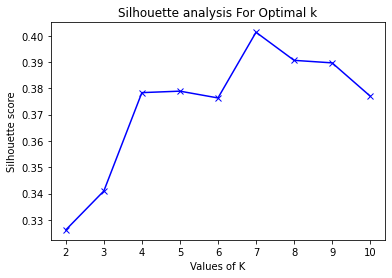

In [35]:
# Clustering silhouette_score
%matplotlib inline
from sklearn.mixture import GaussianMixture
sil_scores = []
# trying different number of clusters
for k in range(2, 11):
    model = GaussianMixture(n_components=k,random_state=20).fit(scores)
    label = model.predict(scores)
    sil_coeff = silhouette_score(scores, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {:.3f}".format(k,sil_coeff))
    sil_scores.append(sil_coeff)
    
plt.plot(range(2,11),sil_scores,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [36]:
#GaussianMixture Clustering
gm = GaussianMixture(n_components=7,random_state=20)

In [37]:
# Define a custom scoring function using silhouette_score
def custom_silhouette_score(estimator, scores):
    labels = estimator.fit_predict(scores)
    return silhouette_score(scores, labels)

param_grid = {
    
    'max_iter': [50, 100, 200],               # Maximum number of iterations
    'tol': [1e-4, 1e-3, 1e-2],                # Convergence tolerance
}


gm_grid = GridSearchCV(estimator=gm, param_grid=param_grid, scoring=custom_silhouette_score, cv=5)

# Perform the grid search
gm_grid.fit(scores)

# Print the best parameters and corresponding silhouette score
print("Best Parameters:", gm_grid.best_params_)
print("Best Silhouette Score:", gm_grid.best_score_)

Best Parameters: {'max_iter': 50, 'tol': 0.01}
Best Silhouette Score: 0.32716255944923767


In [38]:
gm = GaussianMixture(n_components=7,random_state=20, max_iter =50, tol=0.001)
gm.fit(scores)
gm_pred=gm.predict(scores)

<IPython.core.display.Javascript object>


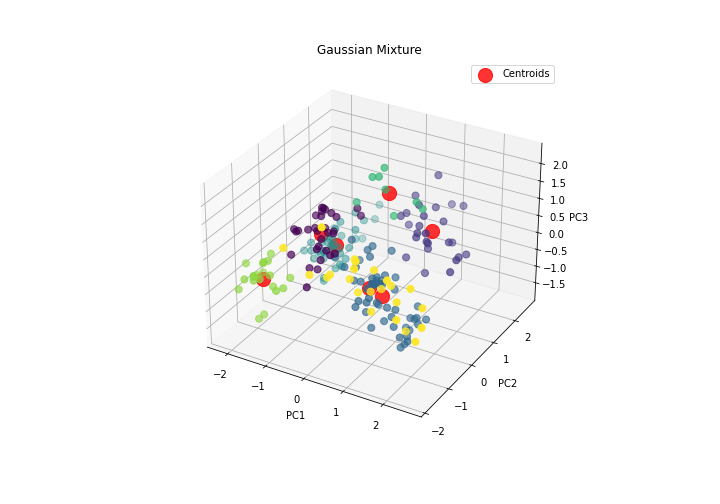

<IPython.core.display.Javascript object>


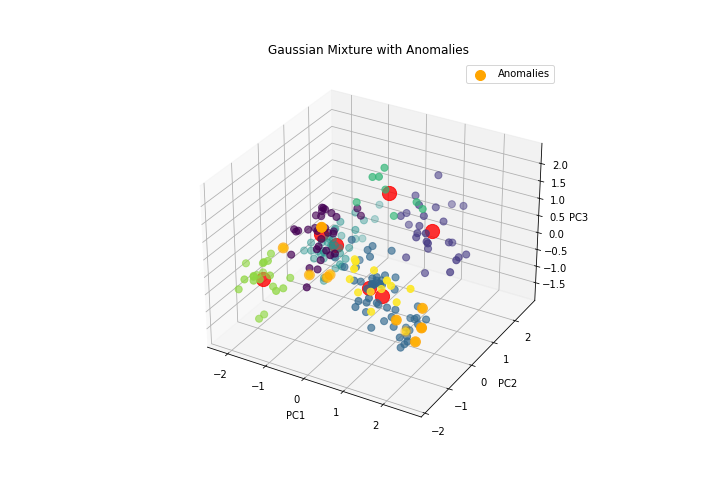

<IPython.core.display.Javascript object>


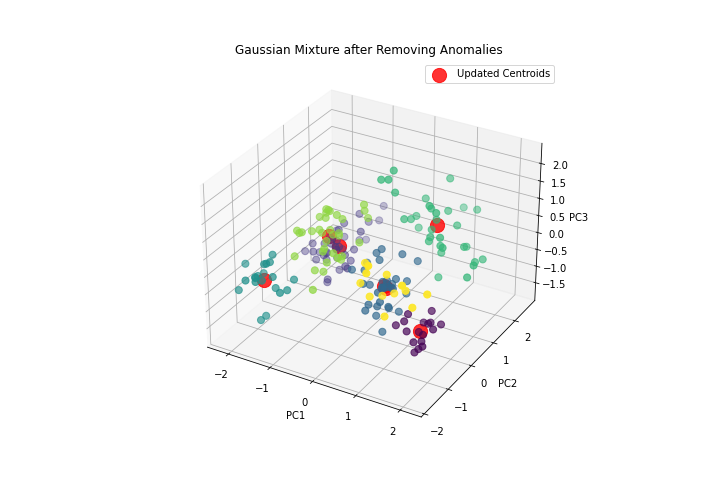

In [42]:
#Calculate centroids for each cluster
%matplotlib notebook
centroids = []
for cluster_id in range(7):
    cluster_points = scores[gm_pred == cluster_id]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scores[:,0], scores[:,1], scores[:,2], c=gm_pred, s=50, cmap='viridis')
plt.title("Gaussian Mixture")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], centroid[2], c='red', s=200, alpha=0.8, label='Centroids' if i==0 else '')
plt.legend()
plt.show()

# # Calculate Mahalanobis distances between data points and cluster representatives
VI = np.linalg.inv(gm.covariances_)
distances = []

for i in range(scores.shape[0]):
    point = scores[i]  # Take the i-th data point
    cluster_id = gm_pred[i]
    centroid = centroids[cluster_id]
    
    # Calculate Mahalanobis distance using scipy's mahalanobis function
    diff = point - centroid
    mahalanobis_dist = mahalanobis(diff, np.zeros_like(diff), VI[cluster_id])
    distances.append(mahalanobis_dist)

distances = np.array(distances)

# Set anomaly threshold (mean + 2 * std)
anomaly_threshold = np.mean(distances) + 2 * np.std(distances)

# Identify anomalies
anomalies_indices = np.where(distances > anomaly_threshold)
anomalies = scores[anomalies_indices]

# Visualize data and anomalies
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2], c=gm_pred, cmap='viridis', s=50)
for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], centroid[2], c='red', s=200, alpha=0.8)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("Gaussian Mixture with Anomalies")
ax.scatter(anomalies[:, 0], anomalies[:,1], anomalies[:, 2], c='orange', marker='o', s=100, label='Anomalies')
plt.legend()
plt.show()

#Removing Anomalies
new_data = np.delete(scores, anomalies_indices, axis=0)
new_pred = gm.fit_predict(new_data)

#Updated Clustering
updated_centroids = []
for cluster_id in range(7):
    cluster_points = new_data[new_pred == cluster_id]
    centroid = np.mean(cluster_points, axis=0)
    updated_centroids.append(centroid)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_data[:, 0], new_data[:, 1], new_data[:, 2], c=new_pred, cmap='viridis',s=50)
for i, updated_centroid in enumerate(updated_centroids):
    ax.scatter(updated_centroid[0], updated_centroid[1], updated_centroid[2], c='red', s=200, alpha=0.8, label='Updated Centroids' if i == 0 else '')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title('Gaussian Mixture after Removing Anomalies')
plt.legend()

plt.show()

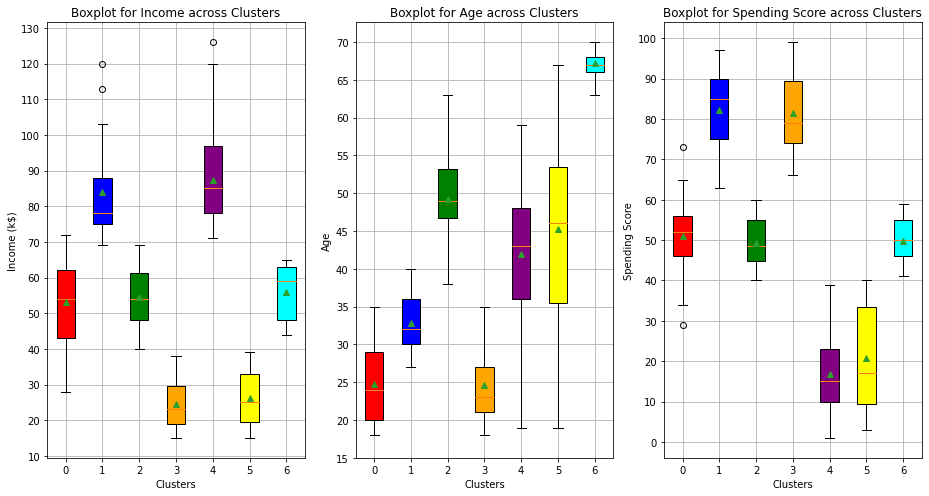

In [40]:
# Create a DataFrame to hold the clustered data along with cluster labels
%matplotlib inline
GaussianMix = pd.DataFrame(X_gender)
GaussianMix = GaussianMix.drop(anomalies_indices[0])
GaussianMix['cluster'] = new_pred

grouped_data =GaussianMix.groupby('cluster')
cluster_labels = list(grouped_data.groups.keys())
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan']
rgba_colors = [mcolors.to_rgba(color) for color in colors]

# Extract the data for the specified feature column for each cluster
agecluster = [grouped_data.get_group(cluster_label)['Age'] for cluster_label in grouped_data.groups]
incomecluster = [grouped_data.get_group(cluster_label)['Income (k$)'] for cluster_label in grouped_data.groups]
spendingcluster = [grouped_data.get_group(cluster_label)['How Much They Spend'] for cluster_label in grouped_data.groups]

plt.figure(figsize=(13, 7))
# Plot for 'Income'
plt.subplot(1, 3, 1)
income_boxplot = plt.boxplot(incomecluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(income_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Income across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Income (k$)')
plt.yticks(np.arange(10, 140, 10))
plt.grid(True)

# Plot for 'Age'
plt.subplot(1, 3, 2)
age_boxplot = plt.boxplot(agecluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(age_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Age across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Age')
plt.yticks(np.arange(15, 75, 5))
plt.grid(True)

# Plot for 'Spending Score'
plt.subplot(1, 3, 3)
spending_boxplot = plt.boxplot(spendingcluster, labels=cluster_labels, patch_artist=True, showmeans=True)
for i, patch in enumerate(spending_boxplot['boxes']):
    patch.set_facecolor(rgba_colors[i])
plt.title('Boxplot for Spending Score across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Spending Score')
plt.yticks(np.arange(0, 110, 10))
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
#Calculate mean of each cluster in the original feature space
gm_data_mean = GaussianMix.groupby('cluster').mean()

print("Mean of each cluster in the original feature space:")
gm_data_mean

Mean of each cluster in the original feature space:


,Gender,Age,Income (k$),How Much They Spend
cluster,,,,
0,0.636364,24.818182,53.090909,51.000000
1,0.567568,32.783784,84.108108,82.324324
2,0.638889,49.277778,54.638889,49.250000
3,0.578947,24.578947,24.473684,81.421053
4,0.454545,41.939394,87.272727,16.727273
5,0.608696,45.217391,26.304348,20.913043
6,0.384615,67.230769,55.846154,49.846154


# Gaussian Mixture Characteristics of Each Customer Clusters

__Cluster 0__

The customers in this cluster have a really wide age range of about 38 to 70. The mean age of this cluster is around 54, which falls within the range of seniors. The customers in this cluster have an average income compared to the rest of the clusters with an income range of about 40k to 71k. The mean income of this cluster is 55.3k. These customers have a spending score range of about 35 to 60 and a mean spending score of about 49.1/100 which is not really significant to the mall.

__Cluster 1__

The customers in this cluster have a small age range of about 27 to 40. The mean age of this cluster is around 32, which falls within the range of young adults. The customers in this cluster have a high income compared to the rest of the clusters with an income range of about 69k to 113k. The mean income of this cluster is 85.2k. These customers have a spending score range of about 63 to 97 and a mean spending score of about 82.1/100 which is noteworthy and certainly a contender for being the most valuable cluster for the mall.

__Cluster 2__

The customers in this cluster have an age range of about 18 to 37. The mean age of this cluster is around 24, which falls within the range of young adults. The customers in this cluster have an average income compared to the rest of the clusters with an income range of about 39k to 77k. The mean income of this cluster is 55.0k. These customers have a wide spending score range of about 29 to 65 and a mean spending score of about 49.9/100  which is not really significant to the mall.

__Cluster 3__

The customers in this cluster have a fairly wide age range of about 36 to 59. The mean age of this cluster is around 46, which falls within the range of middle aged adults. The customers in this cluster have the highest income with an income range of about 71k to 126k. The mean income of this cluster is 89.7k. These customers have a spending score range of about 5 to 39 and a mean spending score of about 19.5/100 which is surprising due to their high income and is not really significant to the mall.

__Cluster 4__

The customers in this cluster have an age range of about 19 to 36. The mean age of this cluster is around 27, which falls within the range of young adults. The customers in this cluster have a fairly high income compared to the rest of the clusters with a really narrow income range of about 72k to 81k. The mean income of this cluster is 78.3k. These customers have a spending score range of about 1 to 12 and a mean spending score of about 6.3/100 which is surprising due to thier high income but also their very low spending score and is not really significant to the mall.

__Cluster 5__

The customers in this cluster have an age range of about 18 to 35. The mean age of this cluster is around 25, which falls within the range of young adults. The customers in this cluster have the lowest income with an income range of about 15k to 39k. The mean income of this cluster is 25.0k. These customers have a spending score range of about 66 to 99 and a mean spending score of about 81.0/100 which is surprising since their income is very low yet they still have a spending score equal to those with a much higher income. Based on their spending behavior, it appears that these customers may be spendthrifts, meaning they tend to spend money freely and often exceed their income levels. They may have specific spending habits or preferences that contribute to their higher spending scores despite their lower income and is certainly a contender for being the most valuable cluster for the mall.

__Cluster 6__

The customers in this cluster have a wide age range 35 to 57. The mean age of this cluster is around 47, which falls within the range of middle aged adults. The customers in this cluster have a fairly low income compared to the rest of the clusters with an income range of about 18k to 39k. The mean income of this cluster is 28.2k. These customers have spending score range of about 4 to 36 and a mean spending score of about 21.3/100 which is not really significant to the mall.

# Gaussian Mixture Conclusion

Overall, Cluster 1, young adults with an average income of 85.2k and Cluster 5, young adults with a spendthrift nature and an low average income of 25.0k are very valuable clusters for the mall.

However __Cluster 1 is the most valuable cluster__ due to its relatively smaller interquartile range of spending scores and it having the highest spending score of all the clusters.

# Most Valuable Group of Customers

After using 3 clustering models and thoroughly evaluating the data, one customer groups emerge as the most prominent. 

Generally, __the most valuable group appears to have an age around the 30s and have a high income level__, across all 3 clustering models, this cluster consistently demonstrates the highest spending scores, funneling the most money to the mall. By focusing on this valuable segment, the mall can implement targeted marketing strategies that cater to their preferences and encourage continued engagement, maximizing profits and building customer loyalty.(eg. The mall could provide convenient amenities such as reserved parking spaces for busy business professionals or extend special business hours to accommodate their schedules) __(Assuming these high income customers are business men or women)__